# Problem 1: More Powerful RNNs (20%)

RNNs are powerful tools for processing sequences. 
In this problem we'll explore a powerful variant/addition.


While powerful sequences processors, RNNs work one element at a time.
Therefore, RNNs can "miss out" on understanding a given word, if important context comes after 
that word in the sequence. 


Also, notice, that while reading backwards is more difficult, we can still learn a lot. For example

 - ```sanitizer hand bought and store the to went I yesterday```


In this problem, we'll make more powerful RNNs that can gain additional context by reading 
documents from beginning to end, as well as from end to beginning. 

## Part 0 Load the data

In [1]:
import numpy as np
import pandas as pd
%pylab inline
np.random.seed(1234)

import glob
import os

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
def load_imdb_data_text(imdb_data_dir, random_seed=1234):
    train_dir = os.path.join(imdb_data_dir, "train")
    test_dir = os.path.join(imdb_data_dir, "test")

    np.random.seed(random_seed)
    texts = []
    targets = []
    for label in ("pos", "neg"):
        data_dir = os.path.join(train_dir, label)
        files = glob.glob(os.path.join(data_dir, "*.txt"))
        for filename in files:
            with open(filename) as fi:
                text = fi.read()
            target = label == "pos"
            texts.append(text)
            targets.append(target)

    train_docs = texts
    y_train = np.array(targets)

    texts = []
    targets = []
    for label in ("pos", "neg"):
        data_dir = os.path.join(test_dir, label)
        files = glob.glob(os.path.join(data_dir, "*.txt"))
        for filename in files:
            with open(filename) as fi:
                text = fi.read()
            target = label == "pos"
            texts.append(text)
            targets.append(target)

    test_docs = texts
    y_test = np.array(targets)

    inds = np.arange(y_train.shape[0])
    np.random.shuffle(inds)

    train_docs = [train_docs[i] for i in inds]
    y_train = y_train[inds]

    return (train_docs, y_train), (test_docs, y_test)

In [24]:
(train_docs, y_train), (test_docs, y_test) = load_imdb_data_text('../HW6/data/aclImdb/')
print(len(train_docs), 'train sequences')

25000 train sequences


In [25]:
#(train_docs, y_train), (test_docs, y_test) = load_imdb_data_text(...

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# tokenize the text keeping the 50k most common words

# turn text into integer sequences
# pad the sequences to 125 elements each

# your code here
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(train_docs)

x_train = tokenizer.texts_to_sequences(train_docs)
x_test = tokenizer.texts_to_sequences(test_docs)

x_train = pad_sequences(x_train, maxlen=125)
x_test = pad_sequences(x_test, maxlen=125)
print(x_train.shape, x_test.shape)

(25000, 125) (25000, 125)


## Part 1: Running in reverse

Create two identical LSTM models and fit them on the IMDB data. 
 - For the first, use our regular recipe
 - For the second, flip every document around so that the sequences are processed in reverse
   - the easiest way to flip the data is to use `np.fliplr` on the data as you feed it to your model


Comment on the results

In [26]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

In [32]:
K.clear_session()


# text_input = Input(shape=(MAX_SEQ_LEN,)....
# the model should
# - embed the word sequences to make a dense representation
# - use an LSTM (or two) to process the sequence
# - use dropout to help with overfitting
# - use one (or more) dense layers to get the output into the right shape

# compile the model
MAX_SEQ_LEN = 125
EMBEDDING_DIM = 100
VOCAB_SIZE = 50000

text_input = Input(shape=(MAX_SEQ_LEN,))
x = Embedding(VOCAB_SIZE, EMBEDDING_DIM)(text_input)
x = LSTM(128, return_sequences=True)(x)
x = Dropout(0.2)(x)
x = LSTM(64)(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(text_input, output)

# Compile the model
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 125)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 125, 100)       │     5,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 125, 128)       │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 125, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,168,769 (19.72 MB)

 Trainable params: 5,168,769 (19.72 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
import funcy


# here is a function you might find handy
def gen_data(x, y, batch_size, fliplr=False):
    """Generate data for our recurrent network
    
    Args:
        x: model inputs encoded as integer sequences
        y: targets (0/1)
        batch size: size of batch to yield
        fliplr: whether to flip the input data
    """
    idx = np.arange(x.shape[0])
    while True:
        np.random.shuffle(idx)
        for chunk in funcy.chunks(batch_size, idx):
            _x = x[chunk]
            _y = y[chunk]
            if fliplr:
                _x = np.flip(_x, axis=-1)
            yield _x, _y

In [29]:

# generate a batch of data with fliplr=True
# turn it back into words (you can use `tokenizer.word_index`)
# make sure it looks like normal, backword english

# Take a small subset of the data for testing
small_x = x_train[:20]
small_y = y_train[:20]

batch_size = 3
data_gen = gen_data(small_x, small_y, batch_size, fliplr=True)
x_batch, y_batch = next(data_gen)

reverse_word_index = {v: k for k, v in tokenizer.word_index.items()}
def sequence_to_text(sequence):
    return ' '.join([reverse_word_index.get(i, '') for i in sequence if i != 0])

print("Reversed sequences in batch:")
for seq in x_batch:
    text = sequence_to_text(seq)
    print("\nReversed text:")
    print(text)

Reversed sequences in batch:

Reversed text:
perfect words other in acted perfectly and directed perfectly cast perfectly written perfectly be to supposed are movies what is stardust good that it's times multiple movie this see to want will 13 of age the over anyone but children young for complex too be may stardust br br enjoy will everyone that tale enchanting an weaves cake layer was experience directing other only whose vaughn matthew director moreover br br spirits high and spirit blithe ala ghosts as return die they as whom princes fighting the as levity of dose perfect the add strong mark and everett rupert adam flemyng jason damsel perfect a makes she yvaine distressed and confused the as appropriate most is danes claire witch evil sexy a lamia as wonderful

Reversed text:
yet words 1000 the reached i have wills chill of characterization cartoon a plays wills chill plays school high in acting better seen i've there nepotism any son granger's plays who actor young and writer the

In [33]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)

# Fit the model, preserving the original order of the data
history = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=5,
                    validation_split=0.2,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 63s 100ms/step - accuracy: 0.7149 - loss: 0.5291 - val_accuracy: 0.8564 - val_loss: 0.3504 - learning_rate: 0.0010
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 62s 99ms/step - accuracy: 0.9199 - loss: 0.2105 - val_accuracy: 0.8590 - val_loss: 0.3654 - learning_rate: 0.0010
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 61s 98ms/step - accuracy: 0.9675 - loss: 0.0974 - val_accuracy: 0.8486 - val_loss: 0.3840 - learning_rate: 0.0010
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 64s 103ms/step - accuracy: 0.9782 - loss: 0.0695 - val_accuracy: 0.8316 - val_loss: 0.4237 - learning_rate: 0.0010


In [34]:
forward_score = model.evaluate(x_test, y_test, verbose=0)
print("Forward model test accuracy:", forward_score[1])

Forward model test accuracy: 0.8423200249671936


In [36]:
K.clear_session()

# make an identical model and fit it, this time flipping the data
MAX_SEQ_LEN = 125
EMBEDDING_DIM = 100
VOCAB_SIZE = 50000

text_input = Input(shape=(MAX_SEQ_LEN,))
x = Embedding(VOCAB_SIZE, EMBEDDING_DIM)(text_input)
x = LSTM(128, return_sequences=True)(x)
x = Dropout(0.2)(x)
x = LSTM(64)(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

reverse_model = Model(text_input, output)

# Compile the model
reverse_model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 125)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 125, 100)       │     5,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 125, 128)       │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 125, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,506,309 (59.15 MB)

 Trainable params: 5,168,769 (19.72 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,337,540 (39.43 MB)

In [37]:
x_train_rev = np.fliplr(x_train)
x_test_rev = np.fliplr(x_test)

reverse_history = reverse_model.fit(x_train_rev, y_train,
                                  batch_size=32,
                                  epochs=5,
                                  validation_split=0.2,
                                  callbacks=[early_stopping, reduce_lr])

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 64s 100ms/step - accuracy: 0.5662 - loss: 0.6818 - val_accuracy: 0.6032 - val_loss: 0.6718 - learning_rate: 0.0010
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 63s 101ms/step - accuracy: 0.6036 - loss: 0.6724 - val_accuracy: 0.6002 - val_loss: 0.6720 - learning_rate: 0.0010
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 64s 102ms/step - accuracy: 0.6042 - loss: 0.6692 - val_accuracy: 0.5794 - val_loss: 0.6756 - learning_rate: 0.0010


In [38]:
reverse_score = reverse_model.evaluate(x_test_rev, y_test, verbose=0)
print("Reverse model test accuracy:", reverse_score[1])

Reverse model test accuracy: 0.6063600182533264


In [ ]:
# put comments here

## Part 2: The bidirectional LSTM

The idea behdind the bidirectional LSTM is to combine a forward and backward LSTM 
in order to reap the benefits of each. In such a scheme, we use two different LSTM
one that processes the sequence in the forward direction and one that processes it 
backward. We combine (concatenate) their outputs to get a more complex and hopefully 
better represntation of the sequence we're trying to process. 


![bidrectional lstm](../lectures/09_intro_to_neural/bi-lstm.jpg)


TODO: Make a model
 - One branch will take the embedded sequence and process it with an LSTM
 - Another branch will use a `Lambda` layer to flip the sequence and then process it with a different LSTM
   - __NB__: `keras.backed.reverse` is a helpful tensor operation
 - Concatenate the branches together
 - Use 1-2 dense layers to get the output into the right shape. 

This recipe will not require flipping the data before it goes into the model. 

### Plot the model in the notebook to confirm two branches that get combined

NB: you could also make __two__ different inputs to the model (one that gets flipped and one that doesn't) and process both with forward LSTMs. This approach is equivalent, but likely harder to implement.

In [40]:
from tensorflow.keras.layers import Lambda, Concatenate

In [41]:
K.clear_session()

# model code here
text_input = Input(shape=(MAX_SEQ_LEN,), dtype="int32")

# embed the sequence
# process the sequence with two different branches
#  - regular (forward) LSTM
#  - a layer that first flips the sequence and then an LSTM
# Dense layers to get the output in the right shape

embedded_sequence = Embedding(tokenizer.num_words + 1, 100)(text_input)

flip_layer = Lambda(lambda x: K.reverse(x, axes=1), name="flipper")  # fix this line
flipped_sequence = flip_layer(embedded_sequence)

# more modeling code here
forward_lstm = LSTM(64, dropout=0.2, recurrent_dropout=0.2)(embedded_sequence)
backward_lstm = LSTM(64, dropout=0.2, recurrent_dropout=0.2)(flipped_sequence)
combined = Concatenate()([forward_lstm, backward_lstm])
x = Dense(32, activation='relu')(combined)
output = Dense(1, activation='sigmoid')(x)

combined_model = Model(text_input, output)

combined_model.compile("adam", loss="binary_crossentropy", metrics=["acc"])
combined_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 125)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 125, 100)  │  5,000,100 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flipper (Lambda)    │ (None, 125, 100)  │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     42,240 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64)        │     42,240 │ flipper[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ lstm[0][0],       │
│ (Concatenate)       │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      4,128 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         33 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,088,741 (19.41 MB)

 Trainable params: 5,088,741 (19.41 MB)

 Non-trainable params: 0 (0.00 B)

Note: you may need to restart the kernel to use updated packages.


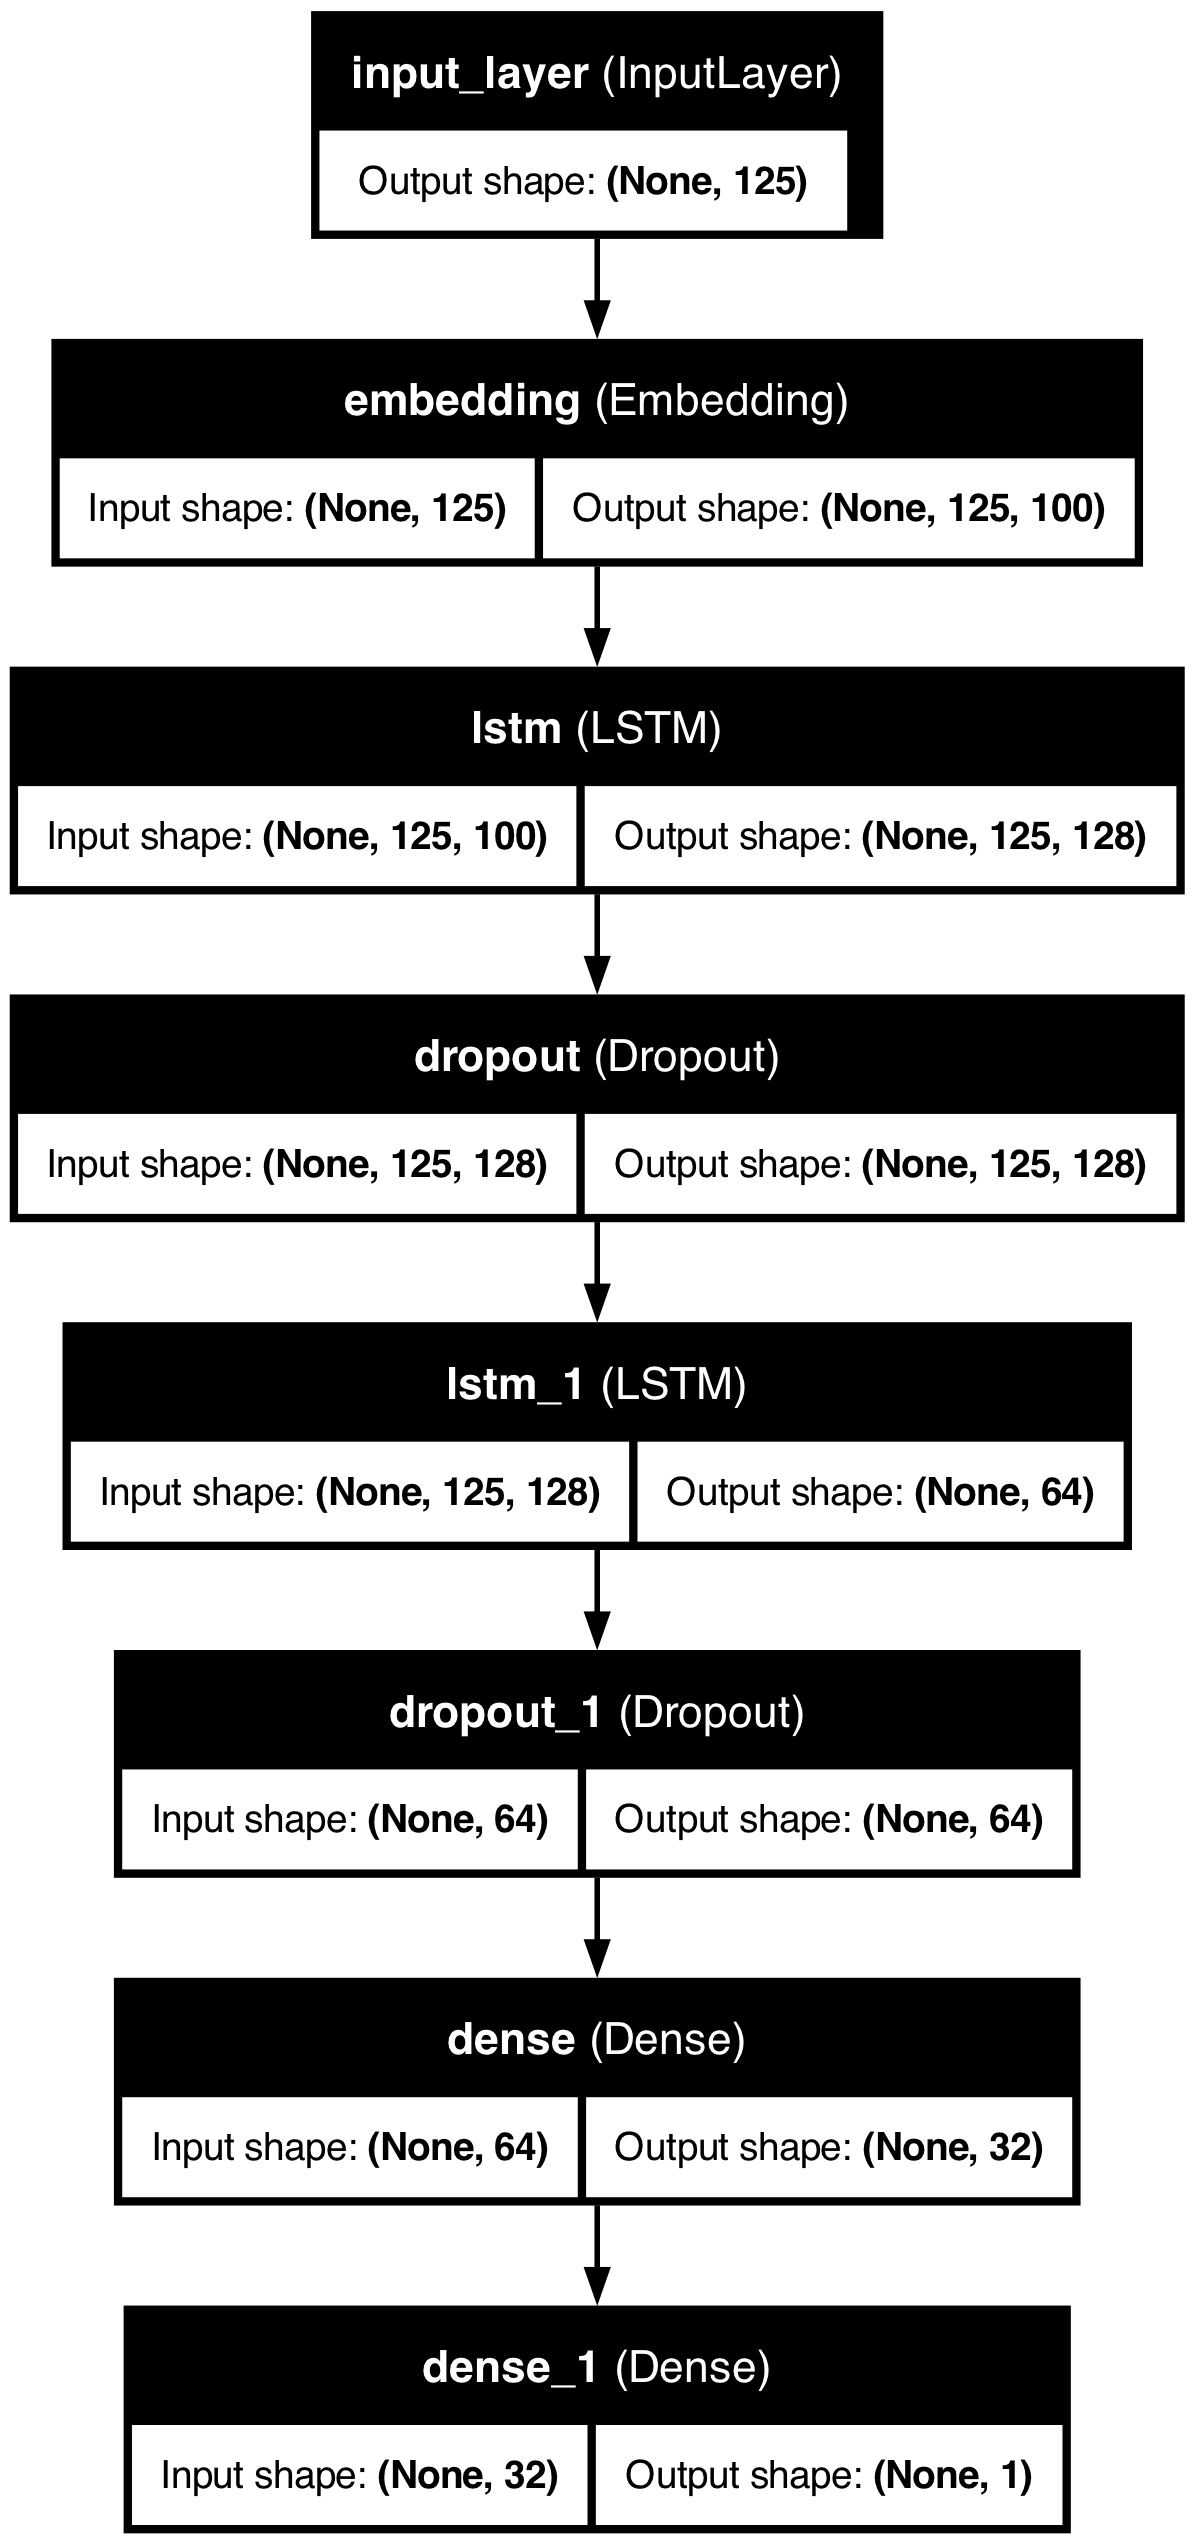

In [43]:
%pip install pydot graphviz

from IPython.display import Image
from tensorflow.keras.utils import model_to_dot

def plot_model_in_notebook(model):
    return Image(model_to_dot(model, show_shapes=True).create(prog='dot', format='png'))

plot_model_in_notebook(model)

## Part 3: Fit the model

 - fit the model feeding in forward sequences. 
 - repeat for backward sequences (remember to re-initialize the model)

Comment on the results
 - how is the performance?
 - does the direction matter when we use a bidirectional lstm?

In [44]:
# fit the modeL
history_forward = combined_model.fit(x_train, y_train,
                          validation_split=0.2,
                          batch_size=32,
                          epochs=5,
                          callbacks=[early_stopping, reduce_lr])

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - acc: 0.6974 - loss: 0.5498 - val_acc: 0.8586 - val_loss: 0.3343 - learning_rate: 0.0010
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 62ms/step - acc: 0.9126 - loss: 0.2312 - val_acc: 0.8310 - val_loss: 0.4112 - learning_rate: 0.0010
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 60ms/step - acc: 0.9481 - loss: 0.1449 - val_acc: 0.8636 - val_loss: 0.3953 - learning_rate: 0.0010
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 60ms/step - acc: 0.9768 - loss: 0.0703 - val_acc: 0.8500 - val_loss: 0.4622 - learning_rate: 0.0010


In [45]:
# reinitialize the model
# (just re-make it)
K.clear_session()

text_input = Input(shape=(MAX_SEQ_LEN,), dtype="int32")
embedded_sequence = Embedding(tokenizer.num_words + 1, 100)(text_input)

flip_layer = Lambda(lambda x: K.reverse(x, axes=1), name="flipper")  # fix this line
flipped_sequence = flip_layer(embedded_sequence)

forward_lstm = LSTM(64, dropout=0.2, recurrent_dropout=0.2)(embedded_sequence)
backward_lstm = LSTM(64, dropout=0.2, recurrent_dropout=0.2)(flipped_sequence)
combined = Concatenate()([forward_lstm, backward_lstm])
x = Dense(32, activation='relu')(combined)
output = Dense(1, activation='sigmoid')(x)

combined_model = Model(text_input, output)

combined_model.compile("adam", loss="binary_crossentropy", metrics=["acc"])
combined_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 125)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 125, 100)  │  5,000,100 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flipper (Lambda)    │ (None, 125, 100)  │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     42,240 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64)        │     42,240 │ flipper[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ lstm[0][0],       │
│ (Concatenate)       │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      4,128 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         33 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,088,741 (19.41 MB)

 Trainable params: 5,088,741 (19.41 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
x_train_reversed = np.flip(x_train, axis=1)
x_test_reversed = np.flip(x_test, axis=1)

# fit the model with reversed sequences
history_reversed = combined_model.fit(x_train_reversed, y_train,
                           validation_split=0.2,
                           batch_size=32,
                           epochs=5,
                           callbacks=[early_stopping, reduce_lr])

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 56ms/step - acc: 0.7008 - loss: 0.5482 - val_acc: 0.8590 - val_loss: 0.3336 - learning_rate: 0.0010
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 61ms/step - acc: 0.9121 - loss: 0.2314 - val_acc: 0.8616 - val_loss: 0.3414 - learning_rate: 0.0010
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 59ms/step - acc: 0.9502 - loss: 0.1369 - val_acc: 0.8406 - val_loss: 0.4307 - learning_rate: 0.0010
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 60ms/step - acc: 0.9783 - loss: 0.0663 - val_acc: 0.8446 - val_loss: 0.4534 - learning_rate: 0.0010


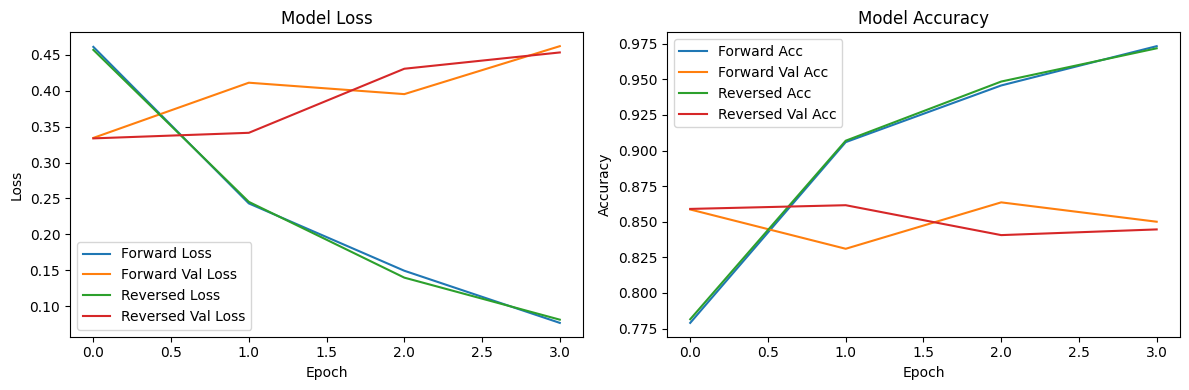

In [47]:
import matplotlib.pyplot as plt

# Plot results for comparison
plt.figure(figsize=(12,4))

# Plot loss
plt.subplot(1,2,1)
plt.plot(history_forward.history['loss'], label='Forward Loss')
plt.plot(history_forward.history['val_loss'], label='Forward Val Loss')
plt.plot(history_reversed.history['loss'], label='Reversed Loss')
plt.plot(history_reversed.history['val_loss'], label='Reversed Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1,2,2)
plt.plot(history_forward.history['acc'], label='Forward Acc')
plt.plot(history_forward.history['val_acc'], label='Forward Val Acc')
plt.plot(history_reversed.history['acc'], label='Reversed Acc')
plt.plot(history_reversed.history['val_acc'], label='Reversed Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Comment on the results
# - how is the performance?
# - does the direction matter when we use a bidirectional lstm?


## Part 4: Use the keras builtin

In fact, keras has a builtin called `Bidirectional` which takes an RNN as an input
and returns a bidirectional version as the output. 

Use this to confirm that it works correctly. 
Comment on the number of parameters in the bidirectional LSTM

In [48]:
from tensorflow.keras.layers import Bidirectional

In [49]:
K.clear_session()
# make a model with a single Bidirectional LSTM using the keras builtin
text_input = Input(shape=(MAX_SEQ_LEN,), dtype="int32")
x = Embedding(tokenizer.num_words + 1, 100)(text_input)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(32, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(text_input, output)
model.compile("adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 125)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 125, 100)       │     5,000,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,088,741 (19.41 MB)

 Trainable params: 5,088,741 (19.41 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
# fit the model
history = model.fit(x_train, y_train,
                   validation_split=0.2,
                   batch_size=32,
                   epochs=5,
                   callbacks=[early_stopping, reduce_lr])

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 56ms/step - acc: 0.7172 - loss: 0.5372 - val_acc: 0.8324 - val_loss: 0.3921 - learning_rate: 0.0010
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 59ms/step - acc: 0.8955 - loss: 0.2627 - val_acc: 0.8540 - val_loss: 0.3489 - learning_rate: 0.0010
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 61ms/step - acc: 0.9451 - loss: 0.1576 - val_acc: 0.8516 - val_loss: 0.4238 - learning_rate: 0.0010


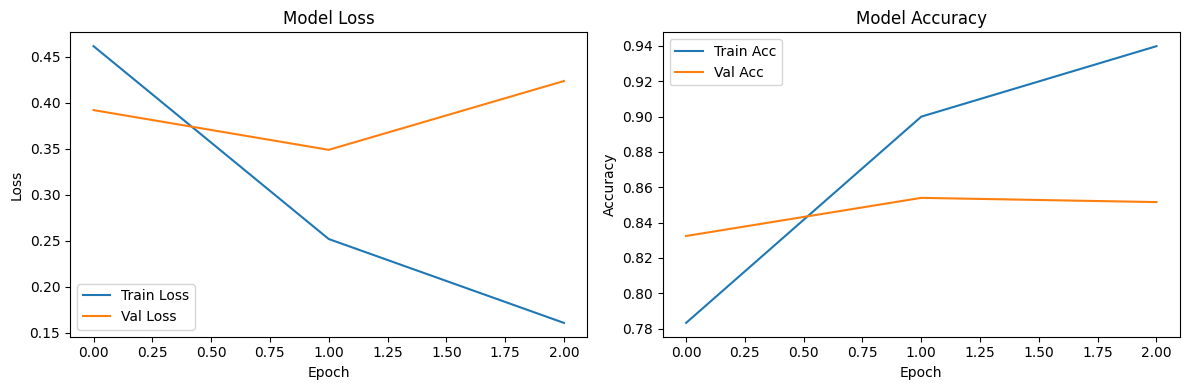

In [51]:
plt.figure(figsize=(12,4))

# Plot loss
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy 
plt.subplot(1,2,2)
plt.plot(history.history['acc'], label='Train Acc')
plt.plot(history.history['val_acc'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Comment on the number of parameters in the bidirectional LSTM


# Problem 2: Data Augmentation (10%)

Another way to prevent overfitting is to augment the data.
More data is always better, but sometimes we can't easily collect more data. 
A set of techniques to turn our current data set into a bigger one are called `data augmentation`. 

Data augmentation can take many forms, and are specific to the data and problem being solve. 
For example, in an image recognition problem, it is very common to rotate, crop, and zoom
images to generate new ones. We can think of this as a form of regularization, since we are, 
in some sense, forcing a pentalty if the model does not have rotation /scale invariance. 
In speech recognition, this can take the form of distoring an audio clip to have higher pitches
(e.g. speeding it up), which should "teach" a model that it should be pitch invariant. 

In text classification problems, it typcially a little more difficult to augment data. 
One common method is known as back-translation: if an autmated machine translation model is 
available, we can translate our text into one language (e.g. english to french) and then back
to the original language again (french to english). This typically yields a very similar 
piece of text to the original, but with different words. 

Here we'll try a simpler approach. In a low-data setting, we do not want the model to be too sensitive
to any given word. Accordingly, we can augment our data by creating additional examples which are 
identical to our current example, but with some words set to unknown words.

This problem is more opened ended.
TODO:
 - Load and process the IMDB sentiment data
 - train two identical models. In one of them, replace some fraction of the words with an unknown token (try `MAX_WORDS + 1`) as the integer encoding for the unknown token)
 - Discuss the results. 
   - What is the result of dropping words.
   - How does it compare to the image / audio methods described here

In [ ]:
import numpy as np
import pandas as pd
%pylab inline
np.random.seed(1234)

import sys
sys.path.insert(0, ".")
from helpers import load_imdb_data_text

In [ ]:
MAX_SEQ_LEN = 125

In [ ]:
import sys
sys.path.insert(0, ".")
from helpers import load_imdb_data_text


#(train_docs, y_train), (test_docs, y_test) = load_imdb_data_text(...

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# tokenize the text keeping the 50k most common words
# turn text into integer sequences
# pad the sequences to 125 elements each


# your code here

In [ ]:
UKNOWN_WORD = tokenizer.num_words + 1

In [ ]:
from tensorflow.keras.layers import Dense, Input, Dropout, GRU, Embedding, LSTM
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

In [ ]:
K.clear_session()


# modeling code here
# consider using
# - the right input shape
# - an embedding that takes us from an integer encoded word 
#   - NB max value is now tokenizer.num_words + 2 because of the unknown word
# - 1-2 LSTMs or GRUs
#  - remember, the last one needs `return_sequences=False`, the rest need it True
# - a Dense layer


# model code here
text_input = Input(shape=(MAX_SEQ_LEN,), dtype="int32")
embedded_sequence = Embedding(tokenizer.num_words + 2, 100)(text_input)
# more code here

model = Model(...)
model.compile("adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

In [ ]:
import funcy
def train_data_gen(batch_size, dropout_frac=0.):
    """training data geneator
    
    Args:
        batch size: size of batch to yield
        dropout_frac: fraction of words to replace with UKNOWN_WORD
    """
    # your code here



In [ ]:
# fit the model
# use `dropout_frac=0`

In [ ]:

# identical model code here
model2 = Model(...)
model2.compile("adam", loss="binary_crossentropy", metrics=["acc"])

# fit it with dropout_frac > 0 (try 0.2 or 0.3)

In [ ]:
# put comments here

# Problem 3: The Company Name Comparer (40%)

A common problem in NLP for finance is automatically comparing two company names to see if they are the same. 
Intuitively, this is a problem that is fairly easy for humans: 
 - `S and P Global` and `S&P Global`
 - `JPMorgan` and `JP Morgan`
 - `Google Inc.` and `Google`

However, the number of ways in which companies can be represented, and the intricacies of corporate 
structure make it difficult to craft rules to capture this behavior.
This makes the problem perfect for a machine learning approach. 
We will see that it is particularly well suited to deep learning, since some 
features will be difficult to craft by hand. 
In the end of this problem we will build a neural network that accepts TWO strings as input
and produces a single floating point output, which is the probability that
the two organizations refer to the same thing. 

In [ ]:
import numpy as np
import pandas as pd
%pylab inline
np.random.seed(1234)

## Part 0: Load the data
Wikipedia is an excellent source of natural language data. 
We need a data set of many ways that we can refer to the same company.
Here we will use the page redicts- if a certain page automatically 
redirects to a second page, we can say with high confidence that the 
title of the first page unambiguously refers to the same thing as 
the second. The lack of ambiguity is important! For example, we 
do not want `Amazon` to be another way to refer to `amazon.com` since
it can also refer to the `amazon river`. See [here](https://en.wikipedia.org/wiki/Amazon) for more.

In `org_redirects.csv` you will find data on the page redirects that have been 
filtered down to everything considered an organization (this is not only companies, 
but it's close). The file has columns
 - `souce_id` a page id for the source page
 - `source_title`: the page title for the source
 - `target_id`: the page id for the page to which the source will redirect
 - `target_title`: the title of the page to which the source redirects
 - `target_qid`: the id of the page in wikidata, the accompanying knowledge graph to wikipedia
 - `edge_type`: the type of organization the target item has in wikidata

For our purposes, we can consider the `source_title` and `target_title` two 
ways to unambiguously refer to the same organization. We will teach an algorithm
to recognize the patterns in these data.


## TODO
 - ## 1. load the data
 - ## 2. Explore the data: 
   - ## what is the distribution of words / characters?
   - ## are there any tokens that are particularly common?
 



In [ ]:
df = pd.read_csv("../../data/org_redirects.csv")
print(df.shape)
df.head()

## Part 1: Process, Clean, and Filter
We need to have the data in slightly more usable form. 
For simplicity, we will want to only deal with lowercase characters. 
Additionally, we will want to remove special characters from the source
and target titles.

Additionally, some redirects require special knowledge, that we don't expect the 
algorithm to be able to learn. 

## TODO: 
 - create two new columns `source_clean` and `target_clean` which are lowercased versions of the original data with the characters `,_/` replaced by spaces
 - NB: remember to drop rows that are now duplicates because of the string cleaning we've done

In [ ]:
import re # probably a useful import 

def normalize_string(s):
    # your code here
    # normalize the data by lowercasing, and replace certain characters with whitespace
    # careful, replace 1 or more whitespace characters with a single whitespace

df["clean_source"] = df["source_title"].apply(normalize_string)
df["clean_target"] = df["target_title"].apply(normalize_string)

# drop the duplicates here. 
# you should have approx 1.1 million examples before dropping duplicates
# and approx 1.04 million examples after

## Part 2: Make training data
We only have positive examples, ie two ways of referring to the same organization. 
We need negative examples in order for the network to learn what is not considered the same orgnanization. 
There are many ways to do this, but we will use the most simple one- random examples from the training data. 

## TODO:
 - ## make another copy of our training data
 - ## shuffle either the source or target columns so that they no longer line up
 - ## add these new data as negative examples to the training data
 - ## split the data into two: train and test 


### Now we have a dataset with approximately 50% positive examples

## TODO (answers these questions in text)
 - ## What are the benefits of this approach
 - ## What are the downsides of this appoach
 - ## What would be a more sophisticated way to generate negative examples


In [ ]:
# wrangle the data here
# you should have approximately twice as many examples now
# the mean `y` value should be about 0.5

In [ ]:
# split randomly into train and test

In [ ]:
# comments here

## Part 3: Turn the data into numpy arrays
We will use a character level representation, since organizations have too
many special words to use a word-level representation. 

Eventually, we will build a neural network that accepts TWO strings as input
and produces a single floating point output, which is the probability that
the source and target refer to the same thing.

### TODO:
 - turn the data into sequences of characters that are integer encoded
   - use the `Tokenizer` with `char_level=True`
   - use `tokenizer.text_to_sequences` to turn the characters into integer-encoded sequences
 - pad the sequences to a constant length of 30 characters
 - write two functions, `train_gen` and `test_gen` which yield data for the network in the right form.
   - data should be yielded as `yield [input_1, input_2], output`
   - you will likely find it easier to have these functions one-hot-encode the characters on the fly instead of holding very large numpy arrays in memory.
 - test your functions and make sure you can recover the original input

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
def text_iterator():
    """This is a helpful iterator
    
    It will yield all the data in `clean_source` and `clean_target` 
    in the training data, without making another copy
    """
    for item in df_train["clean_source"]:
        yield item
    for item in df_train["clean_target"]:
        yield item


tok = Tokenizer(lower=True, char_level=True, num_words=140)
tok.fit_on_texts(text_iterator())

In [ ]:
MAX_SEQ_LEN = 30

In [ ]:
# for both train and test
#   for the src and target
#   - turn each into integer sequence
#   - pad the sequences 
# make y values for both train and test
print(x_train_targ.shape, x_test_targ.shape)

In [ ]:
MAX_CHARS = tok.num_words + 1

In [ ]:
from tensorflow.keras.utils import to_categorical
import funcy


def train_gen(batch_size):
    # your code here
    # the last line should probably look like
    #    `yield [batch_src, batch_targ], batch_y`
    
    # don't forget to one hot encode the characaters
    #   keras.utils.to_categorical is helpful (num_classes=MAX_CHARS)
    
    # if you're feeling enterprising, you can randomly flip
    # the source and target data, which serves as a way to augment
    # the training data. Consider                
#             if np.random.rand() > 0.5:
#                 batch_src, batch_targ = batch_targ, batch_src

            
            

def val_gen(batch_size):
    # your code here, it should be very similar to the function above
    # no need to flip the src and targets randomly

In [ ]:
# check the shapes, make sure you can recover the data and it looks normal

## Part 4: Build and fit a model
The beauty of keras is that it is flexible enough to allow us to do almost arbitrary matrix operations. 
In this model we will use several `Conv1D`-`MaxPooling1D` combinations to
encode or process the organization names. However, we will use the __SAME__ blocks for both 
the source and target names, in order to "force" the network to learn operations that
distill the strings down into features that make them easy to compare.

Build a keras model that 
 - has __two__ text inputs
 - has several conv/pooling blocks to process the inputs
 - uses the __same__ blocks to process both of the text inputs
 - concatentates the result of the convolutions together into one vector
 - use one or more `Dense` layers to output a single (`float`), which is the probability that the two organizations are the same

Hint: `keras.models.Model` can accept lists of inputs and outputs in addition to single tensors. 
 - `model = Model([input_1, input_2], output)`



In [ ]:
from tensorflow.keras.layers import (
    Conv1D,
    MaxPooling1D,
    LSTM,
    Dense,
    Dropout,
    Input,
    Concatenate,
    GlobalMaxPooling1D,
)
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

In [ ]:
K.clear_session()

do = 0.05



left = Input(shape=(MAX_SEQ_LEN, MAX_CHARS))
right = Input(shape=(MAX_SEQ_LEN, MAX_CHARS))


blocks = [
    Conv1D(128, 5, padding="same", activation="relu"),
    MaxPooling1D(3),
    Conv1D(128, 5, padding="same", activation="relu"),
    MaxPooling1D(3),
    Conv1D(64, 5, padding="same", activation="relu"),
    MaxPooling1D(3),
    Conv1D(64, 5, padding="same", activation="relu"),
    GlobalMaxPooling1D()
]

def encode(inpt):
    x = blocks[0](inpt)
    for block in blocks[1:]:
        x = block(x)
    return x

left_stream = encode(left)
right_stream = encode(right)
# TODO:
# - concatenate right and left streams
# - use 2-3 dense blocks to get the output into the right shape 
#    this is a binary classification problem
# - compile your model

# your code here

model = Model([left, right], your_output)
model.compile("adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# user these callbacks

In [ ]:
# fit the model

## Part 5: Analysis
We want to see how our new model works on unseen text. 
Write a function
```python
def compare_inputs(a, b):
    """takes in two strings and returns a float"""
    pass
```
that can use the model to compare two strings. 

TODO
 - Come up with at least 10 examples of your own and comment on the results

TODO: How would this be done without deep learning? 
 - Can we use the same operations on both the source and target?
 - How would we need to combine representations that come from the features we engineer from the two inputs?
 - If we had hand-engineered features, how would we add them to this network?

(answer in text below)

In [ ]:
def compare_inputs(a, b):
    # take two strings, process them the same way we process our training data
    # use `model.predict` to get a probability that they are the same
    # your code here

In [ ]:
for pair in [
    ("The college of Mann", "University of mann"),
    (...) # add lost more examples here
]:
    print("\"{}\" and \"{}\": {:.4f}".format(pair[0], pair[1], compare_inputs(*pair)[0][0]))

In [ ]:
# put analysis / comments here

# Problem 4: Character level word features (30%)

In class we showed that neural networks can learn everything from character-level representations.
Recall the potential advantages
 - We are much less likely to see unknown characters
 - We don't have to worry about word tokenization
 - Maybe `jump` and `jumps` can "share" a lot of the representation
 - There's nothing special about a space 

In fact, there is perhaps something special about a space. 
While the network can, in principle, learn the concept of a word boundary,
we may be able to help the network learn by telling it that words boundaries are
an important concept. This is especially true in smaller-data problems.

In this problem we'll seek to remedy the first and third bullets above by encoding
every __word__ as a sequence of characters. This should allow for the network to implicitly
learn similarities between words with similar letters. In some sense, we can think of 
such an encoding as character-level method for learning word embeddings

## Part 0: Load the data

 - Load the imdb data as we did in class. 
 - Tokenize it into integer sequences

In [1]:
import numpy as np
import pandas as pd
import glob
import os
%pylab inline
np.random.seed(1234)

import sys
sys.path.insert(0, ".")
from helpers import load_imdb_data_text

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import sys
sys.path.insert(0, ".")
from helpers import load_imdb_data_text


#(train_docs, y_train), (test_docs, y_test) = load_imdb_data_text(...

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# tokenize the text keeping the 50k most common words
# turn text into integer sequences
# pad the sequences to 125 elements each


# your code here

## Part 1: Wrangle the data into the correct representation

Our goal is to represent the data as character-level features, word by word. 
This means we will require the data to be in a shape
 - ### batch x word-position x character

which is another dimension!
### 1a
 - create a valid set of characters from `string.ascii_lowercase + string.digits + string.punctuation`
 - create character to int and int to character lookups
 - create word to int and int to word lookups

### 1b
 - for every word (int) in a sequence, resolve it to a list of integers, which encode characters
 - pad each character sequence (which encodes a single word) to a constant length of 10 chars / word

### 1c
 - Pad every word sequence (each now encoded as a list of integer sequences) to 125 words

This should yield training data of the shape `(25000, 125, 10)`  `(examples x words x characters)` of type `int32`

### 1d
 - make sure you can recover a coherent IMDB review from an element in `x_train`

In [4]:
import string
valid_chars = string.ascii_lowercase + string.digits + string.punctuation
valid_chars = list(set(valid_chars))
char_to_int = {c: i + 1 for i, c in enumerate(valid_chars)}  # save 0 for padding
int_to_char = ...

word_to_int = ...
int_to_word = ...

In [5]:
MAX_CHARS_PER_WORD = 10
MAX_SEQ_LEN_WORDS = 125
UNK_CHAR = len(valid_chars) + 2

In [6]:
def word_to_char_seq(word):
    # your code here


def word_seq_to_char_seq(word_seq):
    # your code here

In [ ]:
%%time
char_seqs_train = [word_seq_to_char_seq(ts) for ts in train_sequences]
x_train = pad_sequences(char_seqs_train, maxlen=MAX_SEQ_LEN_WORDS)

char_seqs_test = [word_seq_to_char_seq(ts) for ts in test_sequences]
x_test = pad_sequences(char_seqs_test, maxlen=MAX_SEQ_LEN_WORDS)

x_train.shape, x_test.shape

In [ ]:
# make sure you can recover the original text
" ".join(...

## Part 2: Create a network

Sadly, keras cannot handle our extra dimension gracefully, so we will do a trick.

### TODO
 - One-hot-encode characters for the input layer, so that the network accepts data in a shape `batch x word-seq-index x char-seq-index x char-encoding`. 
 - Reshape this into `(batch x word-seq-index x char-seq-index * char-encodeing)` in the network
 - Use a recurrent network or conv net of your choice for the rest of the modeling
 - fit the model

__NB__: one hot encode the characters on the fly (in the data generators) for memory efficiency

In [10]:
from tensorflow.keras.layers import Input, Reshape, ...
...
import tensorflow.keras.backend as K

In [12]:
MAX_CHARS = UNK_CHAR + 1

In [ ]:
K.clear_session()
char_token_input = Input(...
# your model definition here

model.compile("adam", loss="binary_crossentropy", metrics=["acc"])

In [14]:
from tensorflow.keras.utils import to_categorical
import funcy

def train_gen(batch_size):
    # your code here, be sure to one-hot encode characters on the fly


def val_gen(batch_size):
    # your code here, be sure to one-hot encode characters on the fly

In [ ]:
batch_size = 256
model.fit(
    train_gen(batch_size),
    validation_data=val_gen(batch_size),
    epochs=5,
    steps_per_epoch=x_train.shape[0] // batch_size,
    validation_steps=x_test.shape[0] // batch_size,
)

## Part 3: Discuss results

 - What are the advantages and disadvantages of using character-level word features
 - What are the advantages and disadvantages of the reshaping trick that we did

Put your answers here

## Part 4: Improving our model

In fact, we don't need to use the trick to reshape our data.
What we really want is a character-level convolution model that we can apply word by word. 
Luckily, keras has a Layer (really a layer wrapper) called `TimeDistributed`, which will
apply an operation element by element in a sequence. 

### TODO
 - create a model that is __only__ the character-level encoding of a word.
   - accept a single word as an input (shape=`(MAX_CHARS_PER_WORD, MAX_CHARS)`)
   - the model should reshape the data to `(MAX_CHARS_PER_WORD * MAX_CHARS)`
   - after reshaping the model should apply several convultional blocks to find the features that best represent the word.
   - output should be a single vector of shape `(hidden,)` (try 128)
 - Use the `TimeDistributed` function to apply this entire model, word by word, to a sequence
 - This will yield a `hidden`-d digest of every word
 - Use LSTMs and Dense layers to complete the network and classify the sentiment


__NB__: a model can be applied like any other layer or operation: `ouput = my_model(input_tensor)`

In [17]:
from tensorflow.keras.layers import TimeDistributed

In [ ]:
K.clear_session()


# define the encoder
#(this should work, but feel free to play with it)
conv_layers = [
    Reshape((MAX_CHARS_PER_WORD, MAX_CHARS)),
    Conv1D(256, 3, activation="relu"),
    Conv1D(128, 3, activation="relu"),
    MaxPooling1D(2),
    Conv1D(128, 2, activation="relu"),
    GlobalMaxPooling1D(),
]

from tensorflow.keras.models import Sequential
encoder = Sequential()
for cl in conv_layers:
    encoder.add(cl)


input_shape = (...
inpt = Input(shape=input_shape)
hidden = Reshape(...
hidden = TimeDistributed(encoder)(hidden)
# more model definition here
model.summary()

In [1]:
# fit the model

## Part 5: Analysis

In fact, our new model which we apply word by word can be thought of as a 
learned, non-linear (and somewhat complex) digest or "embedding" of each word
that is learned from the characters that comprise the word.

We can explore what this embedding gives us. 

### TODO:
 - pick a few words and apply the model to them to get their vector representation
 - be sure to include words not in the vocabulary
 - pick a few words and calculate the similarity between their vector representation
 - comment on the results

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
# here are some good words to try
# add a few others
words = [
    "jump",
    "jumped",
    "jumps",
    "leap",
    "leaps",
    "tuesday",
    "wednesday",
    "bad",
    "funny",
    "hilarious",
    "scary",
    "exemplary",
    "exemplerey", #spelling error
    "happy", 
    "unhappy",  # added a prefix
    "wrogye", # made up
    "unwrogye", # opposite of made up
    "wrogyed", # past tense made up
]

# your code to get the encoder inputs
# don't forget to pad the encoder inputs
# your code here
# ...
extracted_word_vectors = encoder.predict(encoder_inputs, batch_size=batch_size)
cs = cosine_similarity(extracted_word_vectors)
pd.DataFrame(cs, index=words, columns=words)